In [1]:
import csv, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
time_max = 200

df_apple = pd.read_csv('../data/apple_prices.csv', names=['Price'], header=None)
apple = df_apple.Price.tolist()
apple = apple[:time_max]

mean = 0
std = 1
num_samples = 100
w_noise = np.random.normal(mean, std, size=num_samples)

In [3]:
# Returns an n period exponential moving average for the time series data
def ema(x, n):
    
    ema = []
    time = 1
    
    # get the average of the first n data points
    head = sum(x[:n])/n
    multiplier = 2/float(1 + n)
    ema.append(head)

    # EMA(current) = ((Price(current) - EMA(prev) ) * Multiplier) + EMA(prev)
    ema.append(((x[n] - head) * multiplier) + head)

    # calculate the rest of the values
    for price in x[n+1:]:
        tmp = ((price - ema[time]) * multiplier) + ema[time]
        time = time + 1
        ema.append(tmp)
    return ema

In [4]:
def arma_filter(phis, thetas, x):
    phis_len = len(phis)
    thetas_len = len(thetas)
    x_len = len(x)
    res = np.zeros(x_len)

    for i in range(x_len):
        tmp = 0
        # Moving Average
        for j in range(thetas_len):
            if (i-j) < 0:
                continue
            tmp += thetas[j] * x[i-j]
        # Autoregressive
        for k in range(1, phis_len):
            if (i-k) < 0:
                continue
            tmp += phis[k] * res[i-k]
        
        tmp = tmp/phis[0]
        res[i] = tmp

    return res

In [5]:
def arma_to_ma(phis, thetas, order):
    p = len(phis)
    t = len(thetas)
    result = np.zeros(order)
    
    if (t < order):
        for i in range(t, order):
            thetas.append(0)
    if (p < order):
        for i in range(p, order):
            phis.append(0)
    
    result[0] = 1
    for i in range(order-1):
        result[i+1] = thetas[i+1]
        for j in range((min(i, p)+1)):
            result[i+1] = result[i+1] - result[i-j]*phis[j+1]
    return result

In [6]:
def ARMAtoMA(phis, thetas, m):
    p = len(phis)
    q = len(thetas)

    res = [0]*m
    
    for i in range(m):
        if i < q:
            tmp = thetas[i]
        else:
            tmp = 0.0
        for j in range(min(i+1, p)):
            if i-j-1 >= 0:
                tmp += phis[j]*res[i-j-1]
            else:
                tmp += phis[j]*1.0
        res[i] = tmp;
    return res;

In [7]:
# ema12_plaintext = ema(apple, 12)
# phis = [1., -0.65]
# thetas = [1.]
# lags = 10

phis = [1., -0.8]
thetas = [1., 0.5, 0.2]
lags = 10
arma_apple = arma_filter(phis, thetas, apple)

ma_cof_1 = arma_to_ma(phis, thetas, lags)
ma_apple_1 = arma_filter([1.], ma_cof_1, apple)

ma_cof_2 = ARMAtoMA(phis, thetas, lags)
ma_apple_2 = arma_filter([1.], ma_cof_2, apple)

print(ma_cof_1)
print(ma_cof_2)

[1.         1.3        1.24       0.992      0.7936     0.63488
 0.507904   0.4063232  0.32505856 0.26004685]
[2.0, 1.7, 0.2999999999999998, -1.0600000000000003, -1.3000000000000003, -0.45199999999999996, 0.5880000000000003, 0.9496000000000002, 0.47919999999999996, -0.2804800000000003]


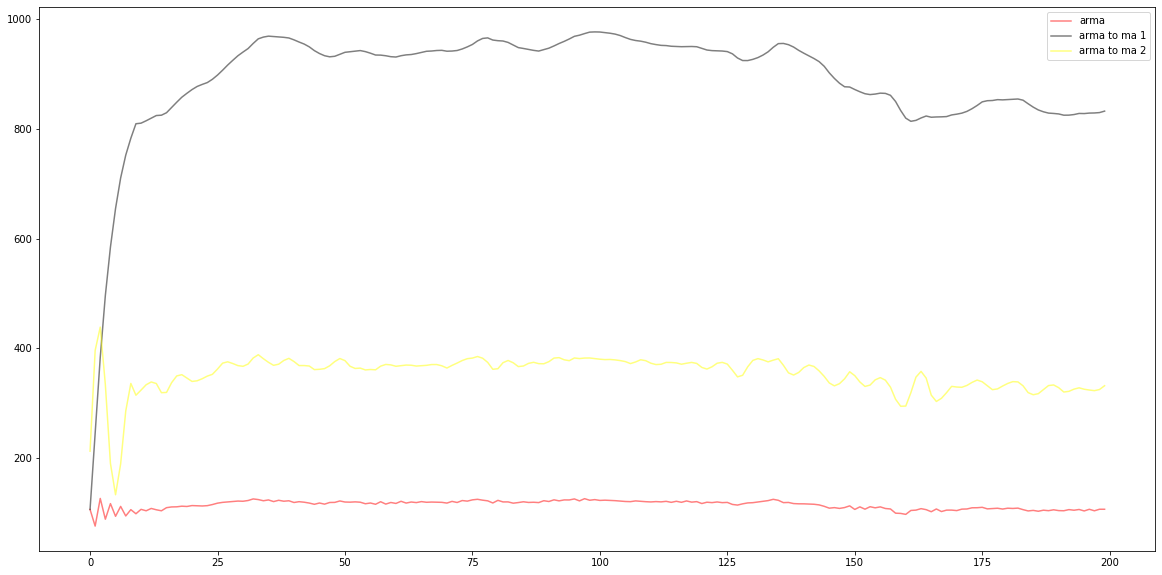

In [8]:
# ema_len = len(ema12_plaintext)
# apple = apple[-ema_len:]
# arma_apple = arma_apple[-ema_len:]
# ma_apple_1 = ma_apple_1[-ema_len:]
# ma_apple_2 = ma_apple_2[-ema_len:]

plt.figure(figsize=(20, 10))
# plt.plot(apple, color='green', alpha=0.5, label='apple')
# plt.plot(ema12_plaintext, color='blue', alpha=0.5, label='ema12')
plt.plot(arma_apple, color='red', alpha=0.5, label='arma')
plt.plot(ma_apple_1, color='black', alpha=0.5, label='arma to ma 1')
plt.plot(ma_apple_2, color='yellow', alpha=0.5, label='arma to ma 2')
plt.legend()
plt.show()

In [9]:
ema12_plaintext_noise = ema(w_noise, 12)
arma_noise = arma_filter(phis, thetas, w_noise)
ma_cof_noise_1 = arma_to_ma(phis, thetas, 10)
ma_noise = arma_filter([1.], ma_cof_noise_1, w_noise)
ma_cof_noise_2 = arma_to_ma(phis, thetas, 10)
ma_noise = arma_filter([1.], ma_cof_noise_2, w_noise)

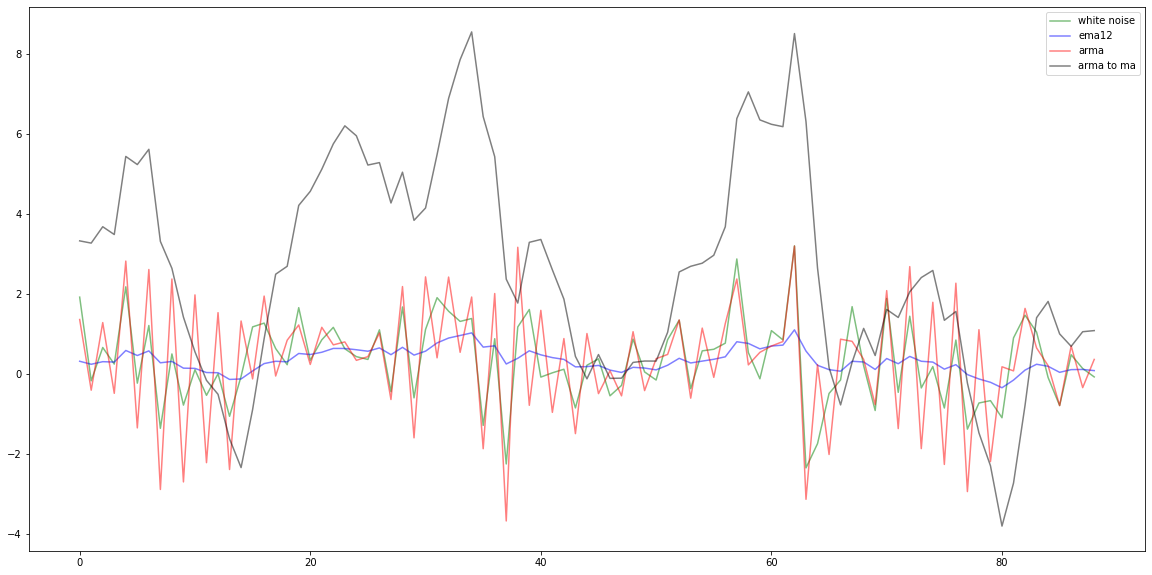

In [10]:
ema_len_noise = len(ema12_plaintext_noise)
w_noise = w_noise[-ema_len_noise:]
arma_noise = arma_noise[-ema_len_noise:]
ma_noise = ma_noise[-ema_len_noise:]

plt.figure(figsize=(20, 10))
plt.plot(w_noise, color='green', alpha=0.5, label='white noise')
plt.plot(ema12_plaintext_noise, color='blue', alpha=0.5, label='ema12')
plt.plot(arma_noise, color='red', alpha=0.5, label='arma')
plt.plot(ma_noise, color='black', alpha=0.5, label='arma to ma')
plt.legend()
plt.show()